# 유사성 기반 방법

## 지수 기반

### 자원 할당

In [1]:
import matplotlib.pyplot as plt

def draw_graph(G, node_names={}, node_size=500):
    pos_nodes = nx.spring_layout(G)
    nx.draw(G, pos_nodes, with_labels=True, node_size=node_size, edge_color='gray', arrowsize=30)
    
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
        
    #nx.draw_networkx_labels(G, pos_attrs, font_family='serif', font_size=20)
    
    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.show()

[(1, 2, 0.5), (2, 5, 0.5), (3, 4, 0.5)]


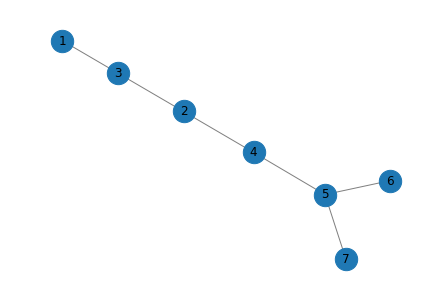

In [2]:
import networkx as nx
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)
preds = nx.resource_allocation_index(G,[(1,2),(2,5),(3,4)])
print(list(preds))
draw_graph(G)

### Jaccard Coefficient

[(1, 2, 0.5), (2, 5, 0.25), (3, 4, 0.3333333333333333)]


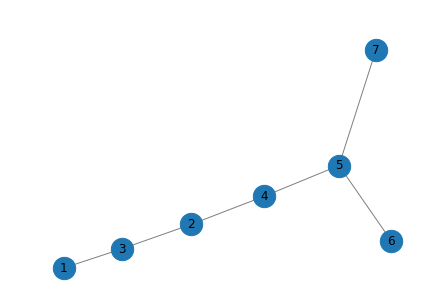

In [3]:
import networkx as nx
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)
preds = nx.jaccard_coefficient(G,[(1,2),(2,5),(3,4)])
print(list(preds))
draw_graph(G)

## 커뮤니티 기반 방법

### 커뮤니티 공통 이웃

[(1, 2, 2), (2, 5, 1), (3, 4, 1)]


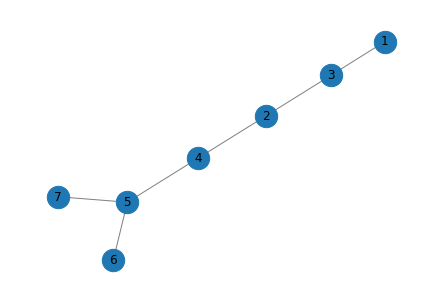

In [4]:
import networkx as nx
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)

G.nodes[1]["community"] = 0
G.nodes[2]["community"] = 0
G.nodes[3]["community"] = 0

G.nodes[4]["community"] = 1
G.nodes[5]["community"] = 1
G.nodes[6]["community"] = 1
G.nodes[7]["community"] = 1
preds = nx.cn_soundarajan_hopcroft(G,[(1,2),(2,5),(3,4)])
print(list(preds))
draw_graph(G)

### 커뮤니티 자원 할당

[(1, 2, 0.5), (2, 5, 0), (3, 4, 0)]


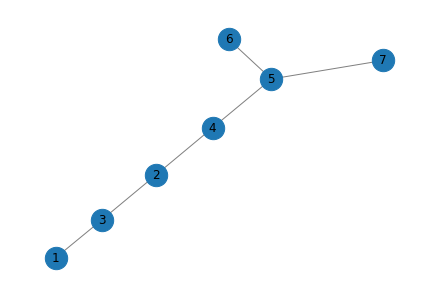

In [5]:
import networkx as nx
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)

G.nodes[1]["community"] = 0
G.nodes[2]["community"] = 0
G.nodes[3]["community"] = 0

G.nodes[4]["community"] = 1
G.nodes[5]["community"] = 1
G.nodes[6]["community"] = 1
G.nodes[7]["community"] = 1
preds = nx.ra_index_soundarajan_hopcroft(G,[(1,2),(2,5),(3,4)])
print(list(preds))
draw_graph(G)

## 임베딩 기반

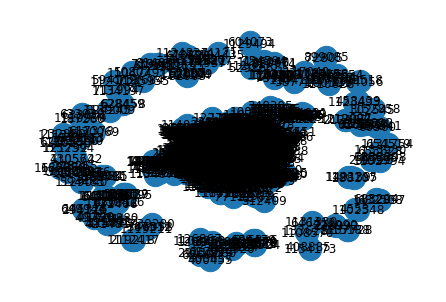

In [6]:
import networkx as nx
import pandas as pd

# https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
# 위 링크에서 데이터셋 다운로드 후 압축 해제

# 압축 cora_cites해제후 파일 경로 입력
cora_cites = 'C:/Users/Public/cora/cora.cites'

edgelist = pd.read_csv(cora_cites, sep='\t', header=None, names=["target", "source"])
G = nx.from_pandas_edgelist(edgelist)
draw_graph(G)

In [7]:
from stellargraph.data import EdgeSplitter

edgeSplitter = EdgeSplitter(G)
graph_test, samples_test, labels_test = edgeSplitter.train_test_split(
    p=0.1, method="global"
)

** Sampled 527 positive and 527 negative edges. **


In [8]:
edgeSplitter = EdgeSplitter(graph_test, G)
graph_train, samples_train, labels_train = edgeSplitter.train_test_split(
    p=0.1, method="global"
)

** Sampled 475 positive and 475 negative edges. **


In [9]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder

node2vec = Node2Vec(graph_train)
model = node2vec.fit()
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)
train_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_train]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [01:08<00:00,  6.87s/it]


In [10]:
test_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_test]

In [11]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(train_embeddings, labels_train);

In [12]:
from sklearn import metrics

y_pred = rf.predict(test_embeddings)

print('Precision:', metrics.precision_score(labels_test, y_pred))
print('Recall:', metrics.recall_score(labels_test, y_pred))
print('F1-Score:', metrics.f1_score(labels_test, y_pred))

Precision: 0.8467908902691511
Recall: 0.7760910815939279
F1-Score: 0.8099009900990098
